<a href="https://colab.research.google.com/github/MingChin100/crawler/blob/master/2_API_Affiliates_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 請輸入資料庫帳號密碼

In [ ]:
username=input('請輸入資料庫username:')
password=input('請輸入資料庫password:')

# 廠商列表

In [ ]:
import requests
import json
import os
url="https://api.affiliates.com.tw/api/v1/affiliates/offers.json?api_key=d3669155fbe8d52640c49bb4808cb49d&has_product_api=1&currency_code=TWD&per_page=50"
response = requests.get(url)
offername=[]
offerid=[]
for offer in response.json()['data']["offers"]:
    offerid.append(offer["id"])
for offer in response.json()['data']["offers"]:
    offername.append(offer["name"])


In [ ]:
offer=zip(offerid, offername)
offer=list(offer)
company=[]
for o in offer:
    company.append(str(list(o)[0])+list(o)[1])
company


In [ ]:
company_dic = {}
for ele in company:
    company_dic[str(ele[0:4])] = ele
    #print(ele[0:4], ele[4:])
company_dic
# num=input()


抓取Affiliates聯盟網的商品頁<BR>
[流程]<BR>
Step1:下載檔案<br>
Step2:存進DB-pages表<br>
Step3:存進DB-products表<br>



# Step1:下載檔案<br>
以requests.get(url)抓取資料<BR>
存檔<br>
已合併Step2存入資料庫。


In [ ]:
url=f'https://api.affiliates.com.tw/api/v1/affiliates/products.json?api_key=d3669155fbe8d52640c49bb4808cb49d&per_page=50&locale=zh-TW&offer_id=1736&product_locale=zh-TW'
response = requests.get(url)
response.json()['status']
response.json()['data'].keys()

dict_keys(['products'])

In [ ]:
offerid0 = [offerid[4]]
offerid0

[3243]

In [ ]:
import requests
import json
import time
import os
import psycopg2
#建立存放資料夾
path="./data"
# os.mkdir(path)
totalproducts=[]
username=input('username')
for i,num in enumerate(offerid):
    print(f"{i} -OFFERID {num}")
    url=f'https://api.affiliates.com.tw/api/v1/affiliates/products.json?api_key=d3669155fbe8d52640c49bb4808cb49d&per_page=50&locale=zh-TW&offer_id={str(num)}&product_locale=zh-TW'
    print(f"即將爬取網址 {url}")
    response = requests.get(url)
    try:
        if (response.json()["data"]["products"]!=[]):
            print(f'商品不為零')
            #一頁存一個檔案
            with open(f'{path}/{num}.json',"w",encoding="utf-8") as file:
                json.dump(response.json()['data'], file, ensure_ascii=False, indent=4)
                print(f'存檔') 
            SQL = "INSERT INTO pages(url, domain, title, content, local_file) VALUES(%s, %s, %s, %s, %s);"
            offer=company_dic[str(num)]
            data = (url,"api.affiliates.com.tw",f'聯盟網-{offer}',json.dumps(response.json()['data']["products"]),username)
            print(data)
            print(f'{offer}共存了{response.json()["data_count_total"]}筆資料')
            
            
            conn=None
            try:
                conn=psycopg2.connect(database="gift_expert_testenv",user=username,password=password,host="172.104.89.11",port="5432")
                print('Connection successful!')
                cur=conn.cursor()
                cur.execute(SQL, data)
                conn.commit()
            except psycopg2.DatabaseError as error:
                print(f'Error{error}')
            finally:
                if conn is not None:
                    conn.close()
            time.sleep(3)
            print("=======================================================================\n")
        else:
            print(f'{offer}沒有商品error\n') 

    except Exception as e:
        print(f"\nERROR!!{num}\n",response.text)
        print(e)
        time.sleep(10)


8筆 Retry later:<br>
3291,3219,3145,2879,2758,2170,1809,1736

16筆 沒有商品 3323 3283 3299

27筆 有匯入資料庫

# Step2:存進DB-pages表<br>
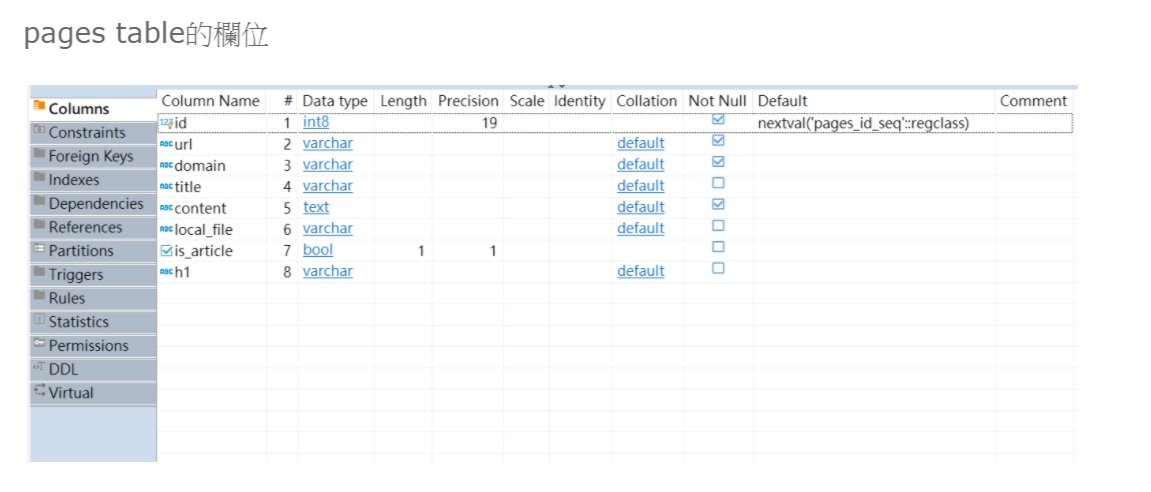


備註：存檔/讀檔不加s，物件轉換加s。<br>
>Use json.load(), not json.loads(), if your input is a file-like object (such as a TextIOWrapper).<br>

步驟二已與步驟一合併，以下為從本地端檔案讀檔存進資料庫的步驟，可略過。

In [ ]:
# import psycopg2
# path="./data"
# page=1
# while page<=283:
#     url=f'http://api.ichannels.com.tw/sitemember/main-goods.php?key=8FMPUF85PIzCD64mTv&member_code=af000121893&page={page}'
#     with open(f'{path}/{page}.json',"r",encoding="utf-8") as file:
#         dataLoad = file.read()
#     SQL = "INSERT INTO pages(url, domain, title, content, local_file) VALUES(%s, %s, %s, %s, %s);"
#     data = (url,"api.ichannels.com.tw",f'通路王第{page}頁',json.dumps(dataLoad),username)
#     conn=None
#     try:
#         conn=psycopg2.connect(database="gift_expert_testenv",user=username,password=password,host="172.104.89.11",port="5432")
#         print('Connection successful!')
#         cur=conn.cursor()
#         cur.execute(SQL, data)
#         conn.commit()
#     except psycopg2.DatabaseError as error:
#         print(f'Error{error}')
#     finally:
#         if conn is not None:
#             conn.close()
#     page+=1

# Step3:存進DB-products表<br>
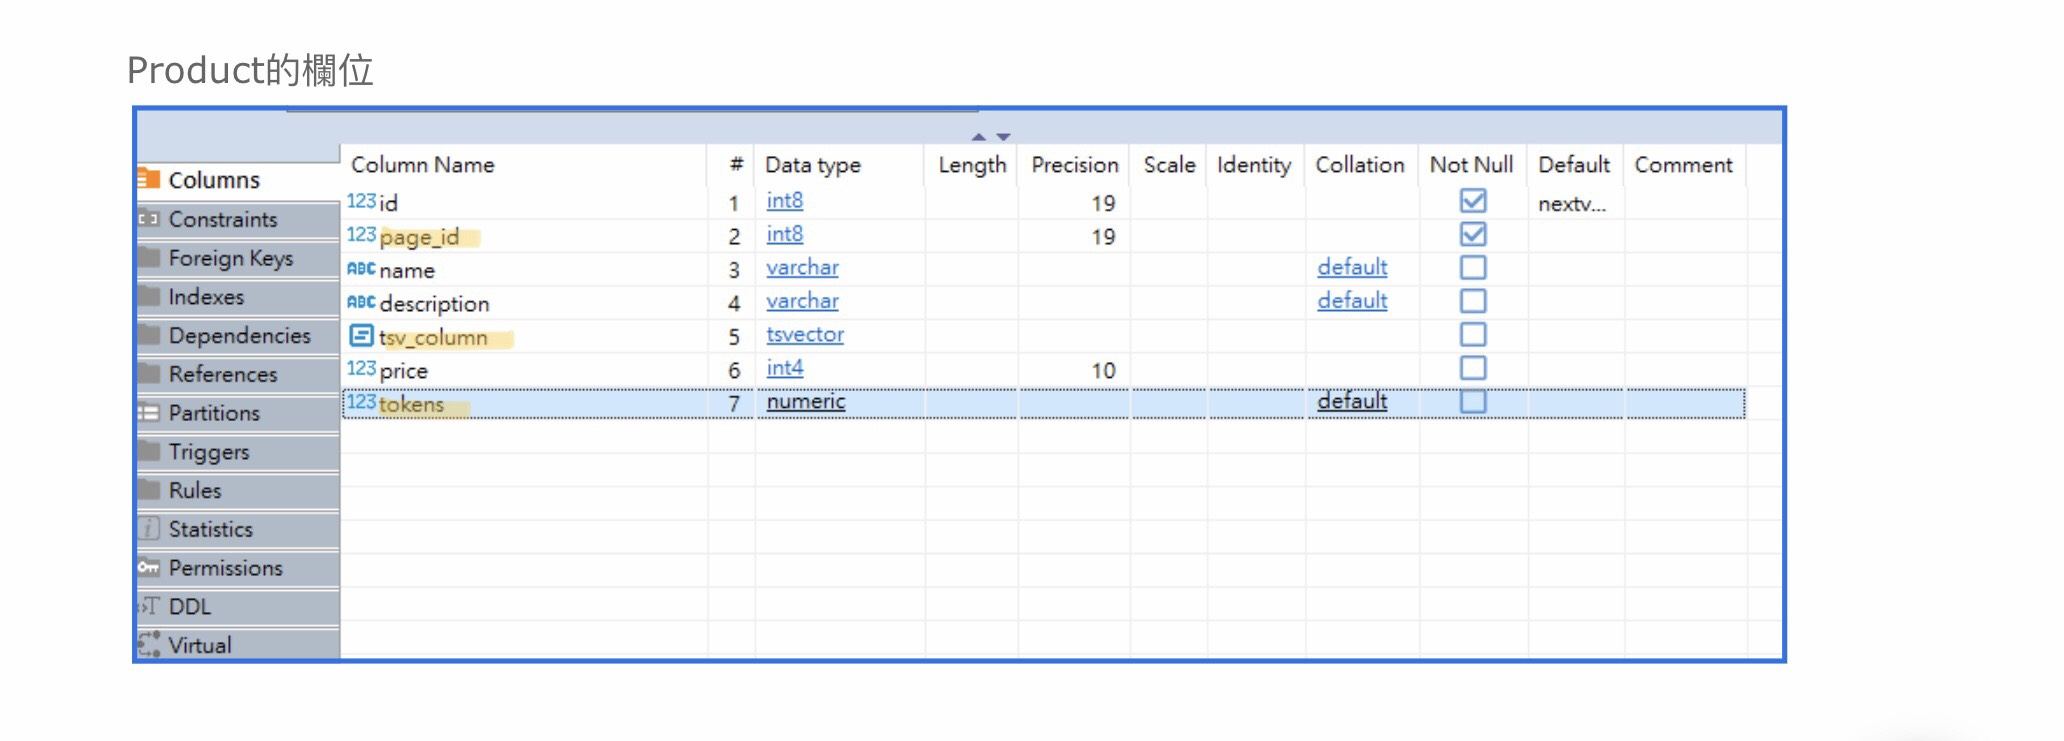

# 讀取資料庫資料(select)

In [ ]:
import psycopg2
conn=None

SQL1="SELECT * FROM pages WHERE domain = 'api.affiliates.com.tw'"
try:
    conn=psycopg2.connect(database="gift_expert_testenv",user=username,password=password,host="172.104.89.11",port="5432")
    print('Connection successful!')
    cur=conn.cursor()
    cur.execute(SQL1)
    ichannel_records = cur.fetchall()
except psycopg2.DatabaseError as error:
    print(f'Error{error}')
finally:
    if conn is not None:
        conn.close()
print(ichannel_records)





ErrorFATAL:  password authentication failed for user "wendy"
FATAL:  password authentication failed for user "wendy"

[(5363432, 'https://api.affiliates.com.tw/api/v1/affiliates/products.json?api_key=d3669155fbe8d52640c49bb4808cb49d&per_page=50&locale=zh-TW&offer_id=1306&product_locale=zh-TW', 'api.affiliates.com.tw', '聯盟網-1306i3Fresh 愛上新鮮', '[{"client_id_value": "1404", "universal_id_value": null, "title": "\\u9bae\\u51cd\\u91d1\\u76ee\\u9c78\\u9b5a\\u584a", "description_1": "\\u91d1\\u76ee\\u9c78\\u9b5a\\u70ba\\u53f0\\u7063\\u9b5a\\u7a2e\\uff0c\\u56e0\\u773c\\u775b\\u53cd\\u5c04\\u7368\\u7279\\u7684\\u91d1\\u7d05\\u8272\\u5149\\u8f1d\\uff0c\\u800c\\u6709\\u91d1\\u76ee\\u9c78\\u9b5a\\u7684\\u7f8e\\u540d\\uff0c\\u5176\\u8089\\u8cea\\u7d30\\u7dfb\\u6ecb\\u5473\\u7518\\u751c\\uff0c\\u66f4\\u662f\\u71df\\u990a\\u88dc\\u7d66\\uff0c\\u6ecb\\u88dc\\u5f37\\u8eab\\u7684\\u7b2c\\u4e00\\u9996\\u9078\\uff01", "description_2": null, "brand": null, "category_1": "\\u9b5a\\u985e", "category_2": "\\u

In [ ]:
# import psycopg2
# conn=None

# SQL2="SELECT id FROM pages WHERE domain = 'api.affiliates.com.tw'"
# try:
#     conn=psycopg2.connect(database="gift_expert_testenv",user=username,password=password,host="172.104.89.11",port="5432")
#     print('Connection successful!')
#     cur=conn.cursor()
#     cur.execute(SQL2)
#     idlist = cur.fetchall()
# except psycopg2.DatabaseError as error:
#     print(f'Error{error}')
# finally:
#     if conn is not None:
#         conn.close()
# newlist = []
# for ele in idlist:
#     newlist.append(list(ele)[0])
# newlist

Connection successful!


[5363432,
 5363431,
 5363430,
 5363429,
 5363428,
 5363427,
 5363426,
 5363425,
 5363423,
 5363424,
 5363422,
 5363421,
 5363420,
 5363419,
 5363418,
 5363416,
 5363417,
 5363414,
 5363415,
 5363413,
 5363412]

# 新增資料
由pages表得到資料新增至products表的欄位

In [ ]:
len(ichannel_records[:1])

1

In [ ]:
import json
conn=psycopg2.connect(database="gift_expert_testenv",user=username,password=password,host="172.104.89.11",port="5432")
print('Connection successful!')
cur=conn.cursor()
i = 0 #offer_id,total=21.from 0 to 20.
j = 0 #product_id
#
for i in range(0,len(ichannel_records)):
    print(f"===換廠商囉,第{i}家===")
    product = ichannel_records[i][4]
    for j in range(0,len(json.loads(product))):        
        prod = json.loads(product)[j]
        # prod(product)[第幾筆商品]
        page_id=ichannel_records[i][0]
        name=prod['title']        
        a=[str(prod['title']),
            str(prod['description_1']),
            str(prod['description_2']),
            str(prod['category_1']),
            str(prod['category_2']),
            str(prod['category_3'])]
        description="-".join(a).replace("None","")
        main_image=prod['images']
        
        if prod['prices']['sale']=={}:
            price=int(float(prod['prices']['retail']['TWD']))
        else:
            price=int(float(prod['prices']['sale']['TWD']))
        promote_url=prod['tracking_url']

        SQL2 = "INSERT INTO products(page_id,name,description,price,promote_url,main_image) VALUES(%s, %s, %s, %s, %s, %s);"
        data=(page_id,name,description,price,promote_url,main_image)
        try:            
            cur.execute(SQL2, data)
            conn.commit()
            print(f"====================存入第{i}家之第{j}項商品==========================")
        except psycopg2.DatabaseError as error:
            print(f'Error{error}')
        print(f"====================end==========================")
conn.close()

In [ ]:
product = ichannel_records[19][4]

len(json.loads(product))
# prod = json.loads(product)[36]
# prod

# print(prod['prices']['retail'])
# print(prod['prices']['sale'])
# #price = int(float(prod['prices']['sale']['TWD']))
# #price = int(float(prod['prices']['retail']['TWD']))
# if prod['prices']['sale']=={}:
#     print("hi")
# #    price=int(float(prod['prices']['retail']['TWD']))

36

前置作業-查看資料內容